In [ ]:
!pip install pystan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00


In [ ]:
import stan
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
import nest_asyncio
nest_asyncio.apply()

In [ ]:
def preprocess_data(data):
    """Preprocess data for RLWM model fitting"""
    df_clean = data[(data['choice'] != -1) &
                    (data['key'] != -1) &
                    (data['cor'] != -1) &
                    (data['rew'] != -1) &
                    (data['rt'] > 0.15)]  # Match MATLAB rt threshold
    return df_clean

In [ ]:
wm_model = """
data {
  int<lower=1> N;                   // Number of trials
  int<lower=1> S;                   // Number of stimuli
  int<lower=1> A;                   // Number of actions
  array[N] int<lower=1, upper=S> stimuli;  // Stimulus on each trial
  array[N] int<lower=1, upper=A> actions;  // Action chosen on each trial
  array[N] int<lower=0, upper=1> rewards;  // Reward received on each trial
  array[N] int<lower=1> set_sizes;  // Set size for the current block
}

parameters {
  real<lower=0, upper=1> epsilon;   // Forgetting/decay parameter
  real<lower=1, upper=10> capacity; // WM capacity parameter
  real<lower=0, upper=1> w0;        // Initial WM weight
  real<lower=0> beta_wm;            // WM inverse temperature
}

model {
  // Priors
  epsilon ~ normal(0.1, 0.1);
  capacity ~ normal(4, 1);
  w0 ~ normal(0.95, 1);
  beta_wm ~ normal(12, 3);

  // Initialize WM values
  array[S] vector[A] Q_wm;
  for (s in 1:S) {
    Q_wm[s] = rep_vector(0.0, A);
  }

  for (t in 1:N) {
    int s = stimuli[t];
    int a = actions[t];

    // Apply decay to WM values (toward uniform)
    for (act in 1:A) {
      Q_wm[s, act] = Q_wm[s, act] + epsilon * ((1.0 / A) - Q_wm[s, act]);
    }

    // Calculate capacity-limited probability
    real p_in_wm = fmin(1.0, capacity / set_sizes[t]);

    // Compute effective WM contribution
    real effective_w = w0 * p_in_wm;

    // Compute choice probabilities
    vector[A] choice_probs;
    vector[A] wm_probs = softmax(beta_wm * Q_wm[s]);

    for (j in 1:A) {
      choice_probs[j] = effective_w * wm_probs[j] + (1 - effective_w) * (1.0 / A);
    }

    // Action selection
    actions[t] ~ categorical(choice_probs);

    // Update WM based on reward
    if (rewards[t] == 1) {
      for (act in 1:A) {
        if (act == a) {
          Q_wm[s, act] = 1.0;
        } else {
          Q_wm[s, act] = 0.0;
        }
      }
    }
  }
}
"""

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

def plot_mcmc_convergence(fit_object, var_names=['epsilon', 'capacity', 'w0', 'beta_wm'], subject_id=None, block_id=None):
    """
    Generates MCMC trace plots matching the example image style for Working Memory model parameters.

    Args:
        fit_object: The fit object returned by compiled_model.sample().
        var_names (list, optional): List of parameter names to plot/summarize.
                                    Defaults to ['epsilon', 'capacity', 'w0', 'beta_wm'].
        subject_id (optional): Identifier for the subject for plot titles.
        block_id (optional): Identifier for the block for plot titles.
    """
    if fit_object is None:
        print("Cannot plot convergence: fit_object is None.")
        return

    # Convert to InferenceData if not already
    if not isinstance(fit_object, az.InferenceData):
        try:
            fit_object = az.convert_to_inference_data(fit_object)
        except Exception as e:
            print(f"Error converting to InferenceData: {e}")
            return

    # Create figure with subplots - one for each parameter
    n_params = len(var_names)
    fig, axes = plt.subplots(1, n_params, figsize=(4*n_params, 4), sharey=False)

    # Handle single parameter case
    if n_params == 1:
        axes = [axes]

    # Define chain colors matching the example image
    chain_colors = ['#FF7F0E', '#9467BD', '#4C2889', '#DBAF57']  # orange, purple, dark purple, light brown

    # Plot each parameter
    for i, var_name in enumerate(var_names):
        if var_name not in fit_object.posterior:
            print(f"Warning: Parameter '{var_name}' not found in fit object.")
            axes[i].text(0.5, 0.5, f"Parameter '{var_name}' not found",
                        ha='center', transform=axes[i].transAxes)
            continue

        # Get parameter data
        param_data = fit_object.posterior[var_name]

        # Handle multidimensional parameters if needed
        if len(param_data.dims) > 2:
            # For multidimensional params, just plot the first element
            if 'chain' in param_data.dims and 'draw' in param_data.dims:
                flat_dims = [d for d in param_data.dims if d not in ['chain', 'draw']]
                if flat_dims:
                    idx = {dim: 0 for dim in flat_dims}
                    param_data = param_data.isel(**idx)
            else:
                print(f"Warning: Parameter '{var_name}' doesn't have expected dimensions.")
                continue

        # Plot each chain
        for c in range(min(len(param_data.chain), 4)):
            chain_data = param_data.sel(chain=c)
            axes[i].plot(chain_data, color=chain_colors[c], linewidth=0.7, alpha=0.9)

        # Set title and labels
        axes[i].set_title(var_name)
        axes[i].set_xlabel("Iteration")

    # Add legend for chain colors
    handles = [plt.Line2D([0], [0], color=color, linewidth=1)
              for color in chain_colors[:min(len(fit_object.posterior.chain), 4)]]
    labels = [str(i+1) for i in range(min(len(fit_object.posterior.chain), 4))]

    # Place legend with "chain" title like in example
    fig.legend(handles, labels, title="chain",
              loc='upper right', bbox_to_anchor=(0.99, 0.99))

    # Set title if subject/block provided
    if subject_id is not None or block_id is not None:
        title = "MCMC Convergence"
        if subject_id is not None:
            title += f" for Subject {subject_id}"
        if block_id is not None:
            if subject_id is not None:
                title += f", Block {block_id}"
            else:
                title += f" for Block {block_id}"
        plt.suptitle(title)

    plt.tight_layout()
    plt.show()

    # Calculate and print summary statistics
    try:
        print("\nCalculating Summary Statistics (including R-hat, ESS)...")
        summary_stats = az.summary(fit_object, var_names=var_names)
        print("Summary Statistics:")
        with pd.option_context('display.max_rows', None,
                             'display.max_columns', None,
                             'display.width', 1000):
            print(summary_stats)
    except Exception as e:
        print(f"Error generating summary statistics: {e}")


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
import math

def fit_wm_model(df, num_chains=4, num_samples=200):
    results = []
    subject_block_groups = df.groupby(['subno', 'block'])
    j=1

    for (subject, block), group_data in subject_block_groups:
        j+=1
        if(j==19):
          break
        print(f"Processing Subject: {subject}, Block: {block}...")

        # Extract set_sizes for the current block
        # Assuming set_size column exists in the dataframe
        set_sizes = group_data['ns'].values.astype(int)

        stan_data = {
            'N': len(group_data),
            'S': int(group_data['ns'].max()),
            'A': 3,
            'stimuli': group_data['stimseq'].values.astype(int),
            'actions': group_data['choice'].values.astype(int),
            'rewards': group_data['rew'].values.astype(int),
            'set_sizes': set_sizes  # Added set_sizes parameter for WM model
        }

        wm_sm = stan.build(wm_model, data=stan_data)  # Using wm_model instead of rl2_model
        wm_fit = wm_sm.sample(
            num_chains=num_chains,
            num_samples=num_samples
        )

        plot_mcmc_convergence(
            fit_object=wm_fit,
            var_names=['epsilon', 'capacity', 'w0', 'beta_wm'],  # WM model parameters
            subject_id=subject,
            block_id=block
        )

        # Extract all 4 WM model parameters
        epsilon_mle = np.ravel(wm_fit['epsilon'])
        capacity_mle = np.ravel(wm_fit['capacity'])
        w0_mle = np.ravel(wm_fit['w0'])
        beta_wm_mle = np.ravel(wm_fit['beta_wm'])
        n_samples = len(epsilon_mle)

        print(f"Number of samples: {n_samples}")

        samples_df = pd.DataFrame({
            'subno': [subject] * n_samples,
            'block': [block] * n_samples,
            'epsilon': epsilon_mle,
            'capacity': capacity_mle,
            'w0': w0_mle,
            'beta_wm': beta_wm_mle
        })

        # Prepare samples for KDE
        epsilon = samples_df['epsilon']
        capacity = samples_df['capacity']
        w0 = samples_df['w0']
        beta_wm = samples_df['beta_wm']
        samples = np.vstack([epsilon, capacity, w0, beta_wm])

        print("Performing Kernel Density Estimation...")
        kde = gaussian_kde(samples)
        print("KDE calculation finished.")

        # Set parameter bounds based on the WM model constraints
        param_bounds = [
            (0.01, 0.99),    # epsilon: 0-1 (centered around 0.1)
            (1.0, 10.0),     # capacity: 1-10 (centered around 5.4)
            (0.5, 1.0),      # w0: 0.5-1 (centered around 0.95)
            (1.0, 30.0)      # beta_wm: 1-30 (centered around 12)
        ]

        def neg_kde(params):
            epsilon, capacity, w0, beta_wm = params
            # Check if parameters are within bounds
            if not (param_bounds[0][0] <= epsilon <= param_bounds[0][1] and
                    param_bounds[1][0] <= capacity <= param_bounds[1][1] and
                    param_bounds[2][0] <= w0 <= param_bounds[2][1] and
                    param_bounds[3][0] <= beta_wm <= param_bounds[3][1]):
                return np.inf
            try:
                density = kde(params)[0]
                return -density if (math.isfinite(density) and density > 0) else np.inf
            except Exception:
                return np.inf

        store = []

        for i in range(100):
            initial_guess = [
                np.random.uniform(param_bounds[0][0], param_bounds[0][1]),  # epsilon
                np.random.uniform(param_bounds[1][0], param_bounds[1][1]),  # capacity
                np.random.uniform(param_bounds[2][0], param_bounds[2][1]),  # w0
                np.random.uniform(param_bounds[3][0], param_bounds[3][1])   # beta_wm
            ]

            print(f"Run {i+1}: Starting optimization from initial guess: epsilon={initial_guess[0]:.4f}, "
                  f"capacity={initial_guess[1]:.4f}, w0={initial_guess[2]:.4f}, beta_wm={initial_guess[3]:.4f}")

            result = minimize(
                fun=neg_kde,
                x0=initial_guess,
                method='L-BFGS-B',
                bounds=param_bounds,
                options={'ftol': 1e-5, 'gtol': 1e-5, 'disp': False}
            )

            if result.success:
                mle_estimate = result.x
                final_density = kde(mle_estimate)[0]
                store.append([mle_estimate[0], mle_estimate[1], mle_estimate[2], mle_estimate[3], final_density])
                print(f"  epsilon: {mle_estimate[0]:.6f}, capacity: {mle_estimate[1]:.6f}, "
                      f"w0: {mle_estimate[2]:.6f}, beta_wm: {mle_estimate[3]:.6f}, KDE density: {final_density:.4g}")
            else:
                print(f"  Optimization failed to converge. Message: {result.message}")

        store_results = pd.DataFrame(store, columns=['epsilon', 'capacity', 'w0', 'beta_wm', 'density'])
        rounded_density = store_results['density'].round(1)
        final_df = store_results[rounded_density == rounded_density.max()]

        print(f"Final epsilon: {final_df['epsilon'].mean():.4f}, Final capacity: {final_df['capacity'].mean():.4f}, "
              f"Final w0: {final_df['w0'].mean():.4f}, Final beta_wm: {final_df['beta_wm'].mean():.4f}")

        results.append([subject, block,
                        final_df['epsilon'].mean(),
                        final_df['capacity'].mean(),
                        final_df['w0'].mean(),
                        final_df['beta_wm'].mean()])

    df_results = pd.DataFrame(results, columns=['subno', 'block', 'epsilon', 'capacity', 'w0', 'beta_wm'])
    return df_results


In [ ]:
data = pd.read_csv('/content/sample_data/expe_data.csv')
df_clean = preprocess_data(data)

Processing Subject: 1, Block: 1...
Building...



Building: 41.9s, done.Messages from stanc:
Warning in '/tmp/httpstan_2psq_ka5/model_54mdzcfm.stan', line 24, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   2% (300/12000)
Sampling:   7% (800/12000)
Sampling:   7% (801/12000)
Sampling:  29% (

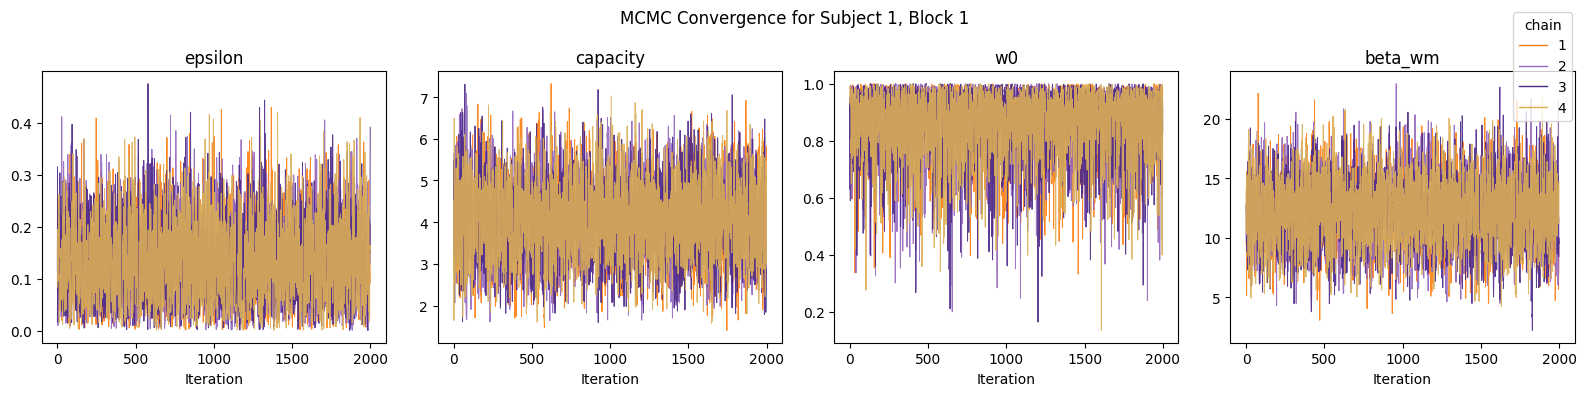


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.127  0.078   0.001    0.263      0.001    0.001    5065.0    2781.0    1.0
capacity   4.024  0.960   2.222    5.806      0.011    0.011    7636.0    4287.0    1.0
w0         0.867  0.122   0.640    1.000      0.001    0.002    6515.0    3812.0    1.0
beta_wm   12.050  2.926   6.658   17.542      0.038    0.036    5877.0    3459.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: epsilon=0.5697, capacity=7.2064, w0=0.5303, beta_wm=4.0657
  epsilon: 0.569716, capacity: 7.206395, w0: 0.530323, beta_wm: 4.065726, KDE density: 5.01e-38
Run 2: Starting optimization from initial guess: epsilon=0.6521, capacity=7.2163, w0=0.9505, beta_wm=21.0260
  epsilon: 0.652123, capacity: 7.216261, w0: 0.950521, beta_wm: 21.025983, KDE 


Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_2psq_ka5/model_54mdzcfm.stan', line 24, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   1% (100/12000)
Sampling:   2% (300/12000)
Sampling:   9% (1100/12000)
Sampli

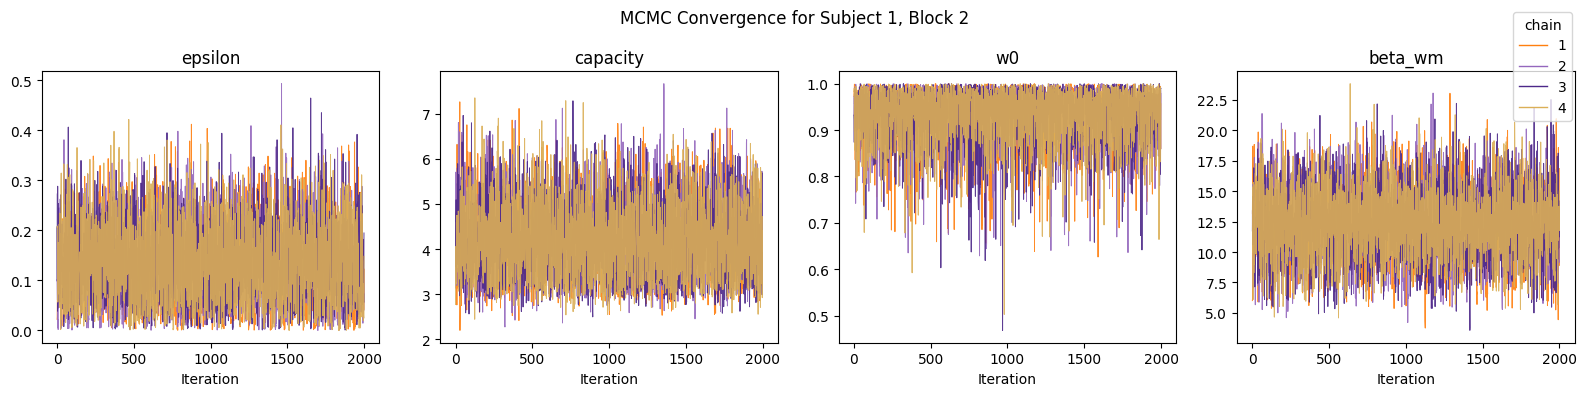


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.126  0.079   0.000    0.262      0.001    0.001    4155.0    2331.0    1.0
capacity   4.226  0.830   2.803    5.728      0.010    0.008    7085.0    5781.0    1.0
w0         0.937  0.059   0.829    1.000      0.001    0.001    5812.0    3359.0    1.0
beta_wm   12.157  2.872   6.719   17.498      0.034    0.031    6895.0    5213.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: epsilon=0.8550, capacity=5.0928, w0=0.5430, beta_wm=26.7495
  epsilon: 0.855002, capacity: 5.092841, w0: 0.543021, beta_wm: 26.749475, KDE density: 6.288e-156
Run 2: Starting optimization from initial guess: epsilon=0.3598, capacity=9.4979, w0=0.5083, beta_wm=27.4035
  epsilon: 0.359795, capacity: 9.497895, w0: 0.508275, beta_wm: 27.403497, 


Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_2psq_ka5/model_54mdzcfm.stan', line 24, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   2% (200/12000)
Sampling:   6% (700/12000)
Sampling:  29% (3500/12000)
Sampli

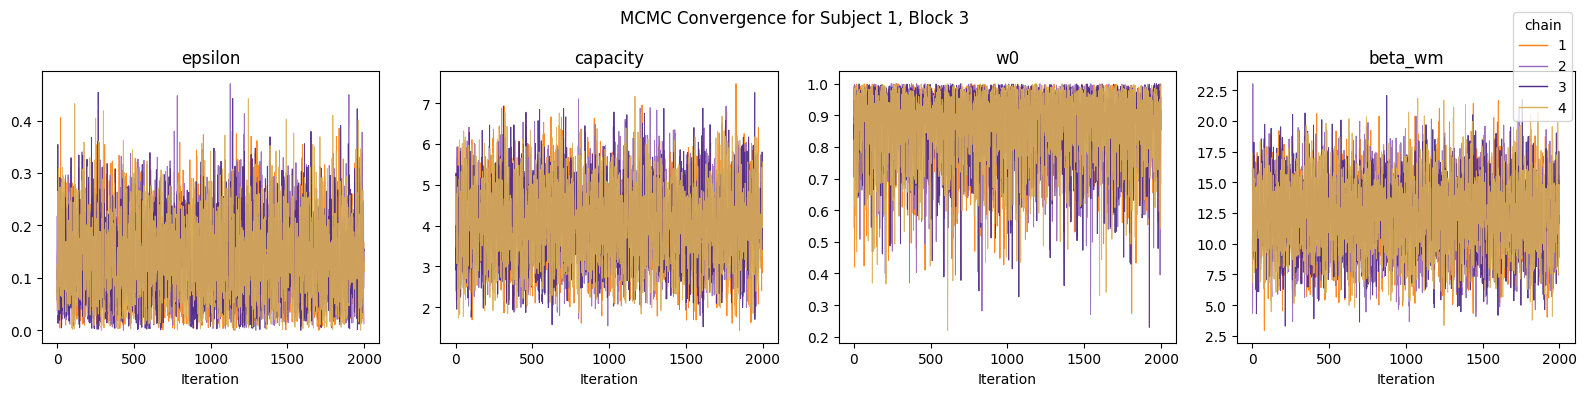


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.129  0.079   0.000    0.264      0.001    0.001    4988.0    2914.0    1.0
capacity   4.033  0.958   2.243    5.825      0.011    0.011    7646.0    4786.0    1.0
w0         0.877  0.110   0.672    1.000      0.001    0.002    6723.0    3735.0    1.0
beta_wm   12.059  2.949   6.573   17.606      0.034    0.033    7502.0    4564.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: epsilon=0.0513, capacity=7.3591, w0=0.5282, beta_wm=12.7682
  epsilon: 0.051149, capacity: 7.359076, w0: 0.528164, beta_wm: 12.768151, KDE density: 4.202e-06
Run 2: Starting optimization from initial guess: epsilon=0.8688, capacity=7.5699, w0=0.7260, beta_wm=4.9824
  epsilon: 0.868831, capacity: 7.569939, w0: 0.726042, beta_wm: 4.982436, KDE


Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_2psq_ka5/model_54mdzcfm.stan', line 24, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   3% (301/12000)
Sampling:  

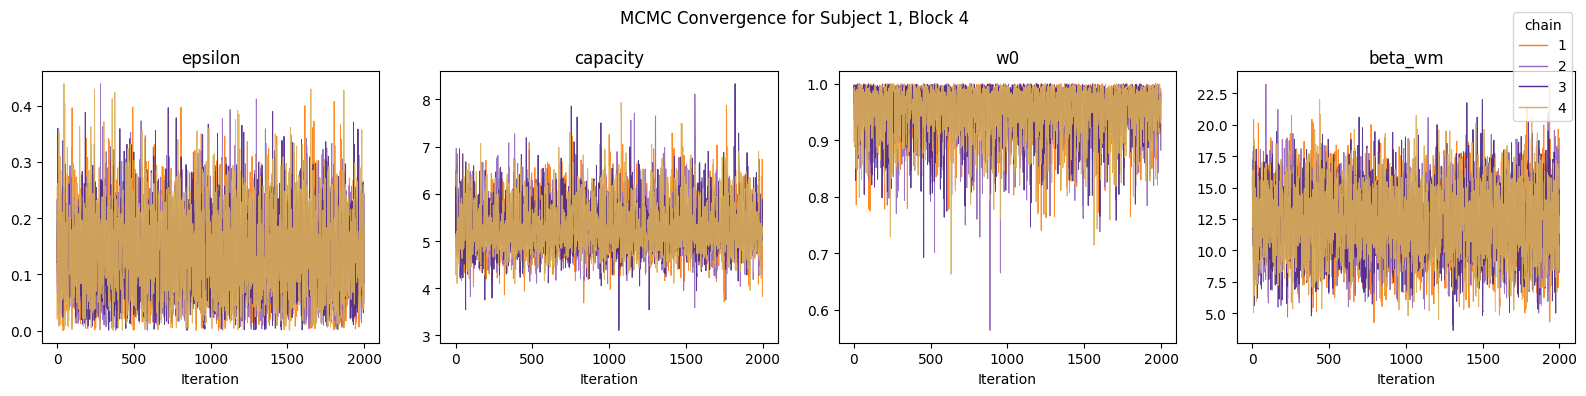


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.129  0.078   0.001    0.258      0.001    0.001    4555.0    2546.0    1.0
capacity   5.298  0.531   4.375    6.382      0.007    0.009    6062.0    4331.0    1.0
w0         0.957  0.042   0.879    1.000      0.000    0.001    5199.0    3317.0    1.0
beta_wm   12.169  2.816   6.933   17.367      0.036    0.031    5970.0    4558.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: epsilon=0.9068, capacity=3.2305, w0=0.6343, beta_wm=18.9396
  epsilon: 0.906847, capacity: 3.230504, w0: 0.634266, beta_wm: 18.939555, KDE density: 2.195e-165
Run 2: Starting optimization from initial guess: epsilon=0.3656, capacity=7.5071, w0=0.8897, beta_wm=16.1594
  epsilon: 0.365603, capacity: 7.507102, w0: 0.889650, beta_wm: 16.159384, 

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  epsilon: 0.484152, capacity: 4.450168, w0: 0.568653, beta_wm: 11.376759, KDE density: 1.276e-36
Run 8: Starting optimization from initial guess: epsilon=0.1752, capacity=8.9995, w0=0.7651, beta_wm=7.5767
  epsilon: 0.175157, capacity: 8.999501, w0: 0.765150, beta_wm: 7.576659, KDE density: 5.842e-38
Run 9: Starting optimization from initial guess: epsilon=0.7401, capacity=7.1090, w0=0.7854, beta_wm=17.0481
  epsilon: 0.740079, capacity: 7.108993, w0: 0.785399, beta_wm: 17.048131, KDE density: 2.25e-63
Run 10: Starting optimization from initial guess: epsilon=0.1863, capacity=5.2078, w0=0.8677, beta_wm=5.3921
  epsilon: 0.267277, capacity: 5.246313, w0: 0.916605, beta_wm: 5.409639, KDE density: 0.07377
Run 11: Starting optimization from initial guess: epsilon=0.6295, capacity=4.3557, w0=0.7318, beta_wm=5.1873
  epsilon: 0.629483, capacity: 4.355750, w0: 0.731848, beta_wm: 5.187295, KDE density: 2.154e-35
Run 12: Starting optimization from initial guess: epsilon=0.8309, capacity=8.1391


Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_2psq_ka5/model_54mdzcfm.stan', line 24, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   1% (101/12000)
Sampling:  

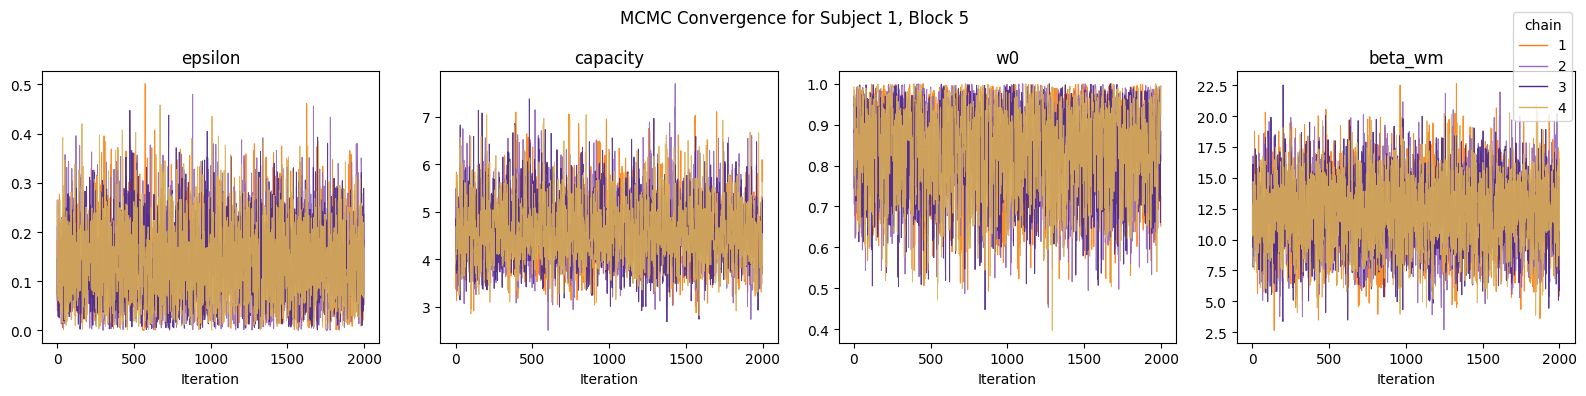


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.131  0.081   0.000    0.269      0.001    0.001    4179.0    2174.0    1.0
capacity   4.626  0.674   3.381    5.897      0.012    0.010    3038.0    3429.0    1.0
w0         0.844  0.107   0.657    1.000      0.002    0.001    2568.0    2430.0    1.0
beta_wm   12.001  2.946   6.348   17.354      0.043    0.034    4548.0    2984.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: epsilon=0.3668, capacity=1.4704, w0=0.8695, beta_wm=19.6099
  epsilon: 0.366801, capacity: 1.470414, w0: 0.869508, beta_wm: 19.609934, KDE density: 1.415e-24
Run 2: Starting optimization from initial guess: epsilon=0.2086, capacity=4.2505, w0=0.6052, beta_wm=2.4835
  epsilon: 0.208602, capacity: 4.250486, w0: 0.605248, beta_wm: 2.483456, KDE


Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_2psq_ka5/model_54mdzcfm.stan', line 24, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   1% (100/12000)
Sampling:   2% (200/12000)
Sampling:   5% (600/12000)
Samplin

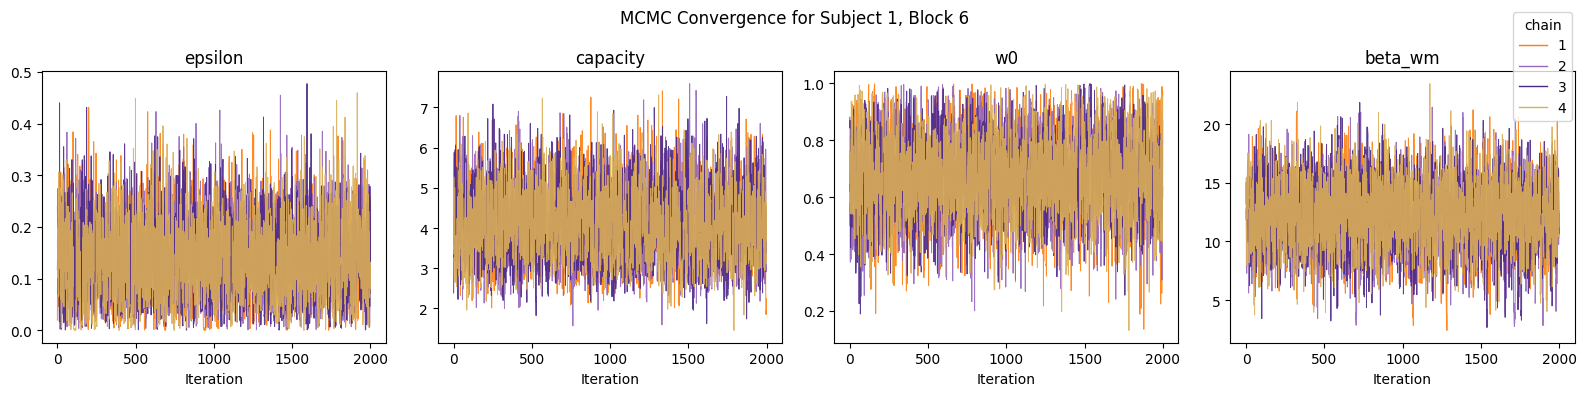


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.130  0.078   0.000    0.262      0.001    0.001    3028.0    1552.0    1.0
capacity   4.081  0.915   2.514    5.825      0.014    0.010    3995.0    3881.0    1.0
w0         0.684  0.144   0.424    0.965      0.002    0.002    4012.0    2556.0    1.0
beta_wm   11.997  3.003   6.255   17.449      0.042    0.040    5175.0    3154.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: epsilon=0.0843, capacity=9.6974, w0=0.6120, beta_wm=19.7331
  epsilon: 0.084298, capacity: 9.697412, w0: 0.612046, beta_wm: 19.733136, KDE density: 4.035e-19
Run 2: Starting optimization from initial guess: epsilon=0.6630, capacity=6.6608, w0=0.9361, beta_wm=17.3738
  epsilon: 0.662958, capacity: 6.660819, w0: 0.936116, beta_wm: 17.373760, K


Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_2psq_ka5/model_54mdzcfm.stan', line 24, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   3% (301/12000)
Sampling:  28% (3300/12000)
Sampling

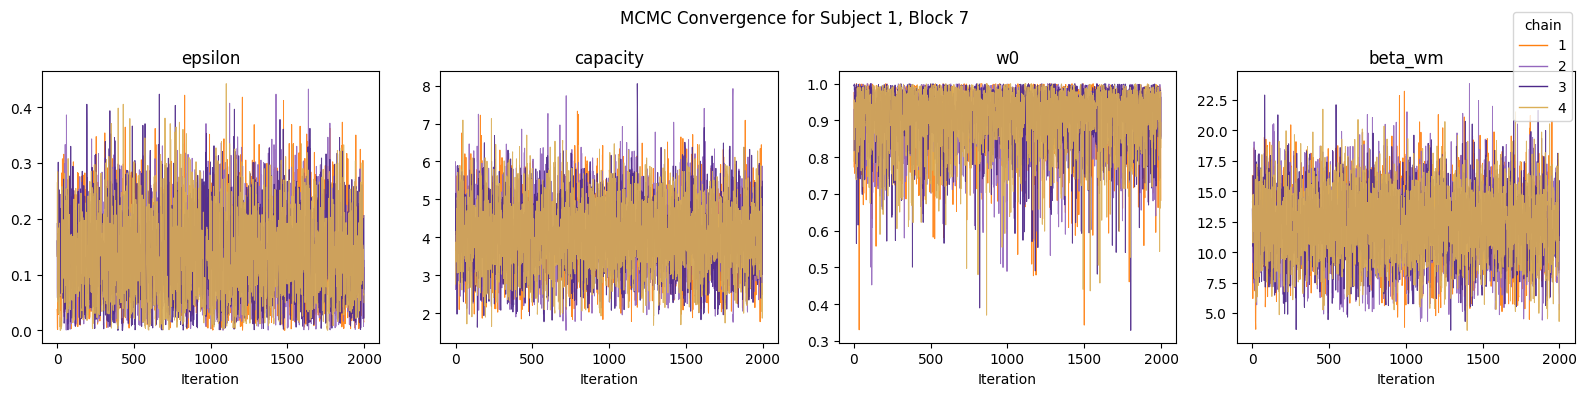


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.128  0.079   0.000    0.263      0.001    0.001    4475.0    2479.0    1.0
capacity   4.037  0.952   2.278    5.838      0.011    0.011    6930.0    4334.0    1.0
w0         0.912  0.084   0.755    1.000      0.001    0.001    5684.0    3356.0    1.0
beta_wm   12.063  2.955   6.403   17.515      0.036    0.033    6732.0    4189.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: epsilon=0.0437, capacity=5.8170, w0=0.9087, beta_wm=2.2115
  epsilon: 0.078007, capacity: 5.700622, w0: 0.868700, beta_wm: 3.645004, KDE density: 0.03023
Run 2: Starting optimization from initial guess: epsilon=0.6765, capacity=2.1321, w0=0.6665, beta_wm=12.7033
  epsilon: 0.676497, capacity: 2.132060, w0: 0.666495, beta_wm: 12.703300, KDE d


Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_2psq_ka5/model_54mdzcfm.stan', line 24, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   1% (100/12000)
Sampling:   2% (200/12000)
Sampling:   4% (500/12000)
Samplin

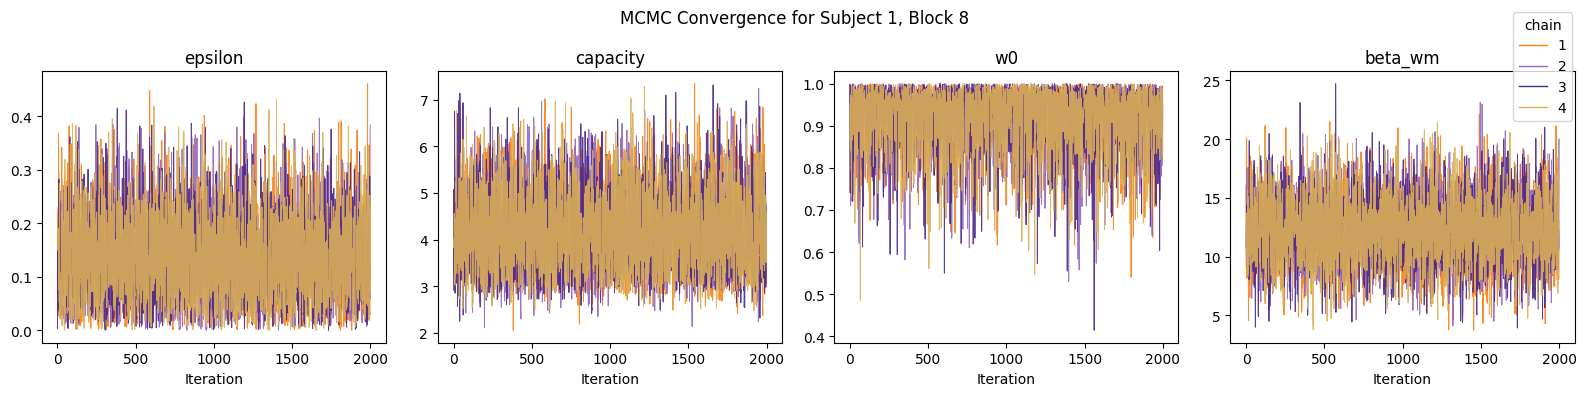


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.129  0.080   0.000    0.266      0.001    0.001    4696.0    2549.0    1.0
capacity   4.212  0.867   2.819    5.854      0.011    0.009    6150.0    5150.0    1.0
w0         0.926  0.071   0.792    1.000      0.001    0.001    5134.0    3306.0    1.0
beta_wm   12.131  2.871   6.553   17.318      0.035    0.034    6467.0    4243.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: epsilon=0.9706, capacity=1.5745, w0=0.9115, beta_wm=11.2782
  epsilon: 0.970617, capacity: 1.574498, w0: 0.911473, beta_wm: 11.278203, KDE density: 1.791e-103
Run 2: Starting optimization from initial guess: epsilon=0.0690, capacity=6.1295, w0=0.6288, beta_wm=28.8540
  epsilon: 0.068959, capacity: 6.129484, w0: 0.628797, beta_wm: 28.854003, 


Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_2psq_ka5/model_54mdzcfm.stan', line 24, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   1% (101/12000)
Sampling:  

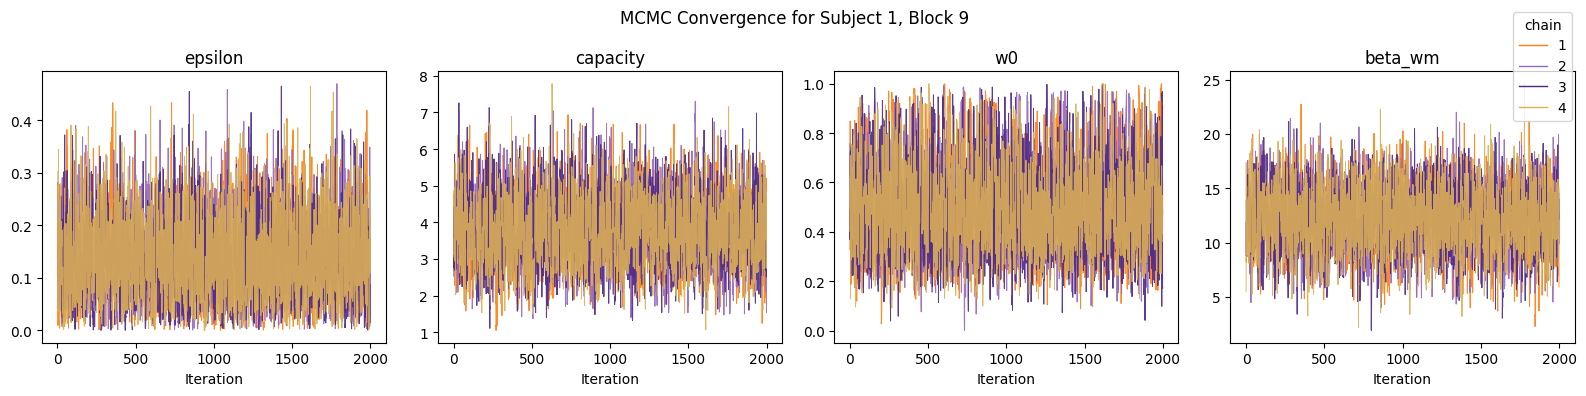


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.131  0.082   0.000    0.270      0.001    0.001    4073.0    2535.0    1.0
capacity   3.750  0.991   1.944    5.610      0.018    0.012    3002.0    2950.0    1.0
w0         0.503  0.190   0.185    0.896      0.003    0.003    3162.0    2139.0    1.0
beta_wm   11.927  2.987   6.040   17.371      0.042    0.036    4972.0    3362.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: epsilon=0.5092, capacity=8.9883, w0=0.9220, beta_wm=17.1551
  epsilon: 0.509182, capacity: 8.988260, w0: 0.922011, beta_wm: 17.155120, KDE density: 3.039e-91
Run 2: Starting optimization from initial guess: epsilon=0.4346, capacity=5.4412, w0=0.8454, beta_wm=4.4621
  epsilon: 0.434630, capacity: 5.441165, w0: 0.845440, beta_wm: 4.462096, KDE


Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_2psq_ka5/model_54mdzcfm.stan', line 24, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   1% (101/12000)
Sampling:  

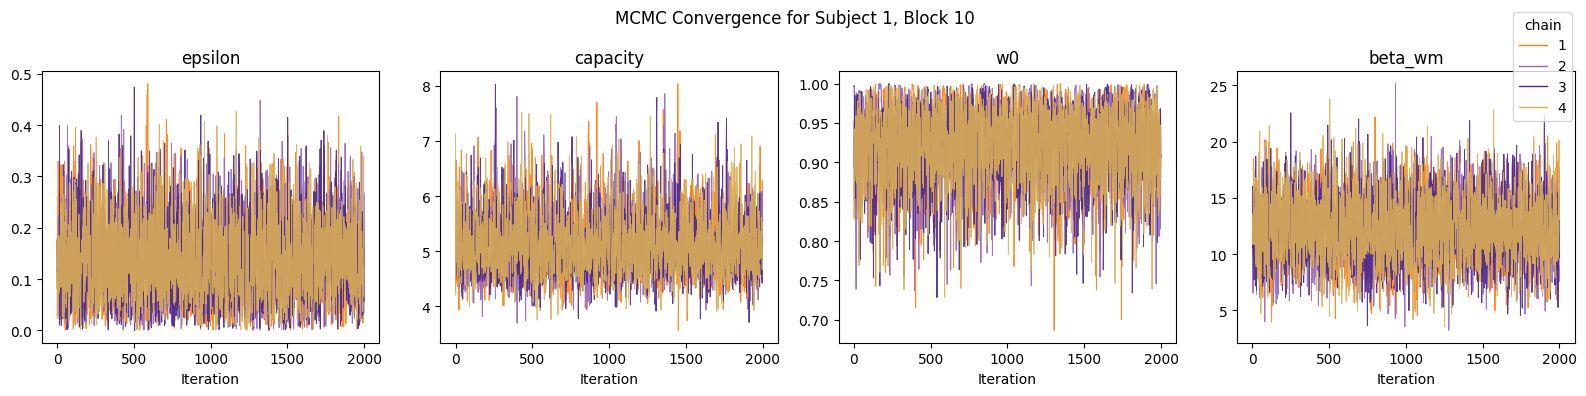


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.130  0.079   0.001    0.266      0.001    0.001    4065.0    2498.0    1.0
capacity   5.131  0.572   4.242    6.305      0.011    0.011    3147.0    3247.0    1.0
w0         0.926  0.047   0.848    1.000      0.001    0.001    2816.0    1674.0    1.0
beta_wm   12.120  2.881   6.711   17.473      0.039    0.034    5200.0    3451.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: epsilon=0.3087, capacity=7.6306, w0=0.6704, beta_wm=18.9831
  epsilon: 0.308701, capacity: 7.630609, w0: 0.670433, beta_wm: 18.983081, KDE density: 2.995e-22
Run 2: Starting optimization from initial guess: epsilon=0.0118, capacity=4.8531, w0=0.9950, beta_wm=26.8000
  epsilon: 0.011791, capacity: 4.853100, w0: 0.995008, beta_wm: 26.800021, K


Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_2psq_ka5/model_54mdzcfm.stan', line 24, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   1% (101/12000)
Sampling:   2% (300/12000)
Sampling:

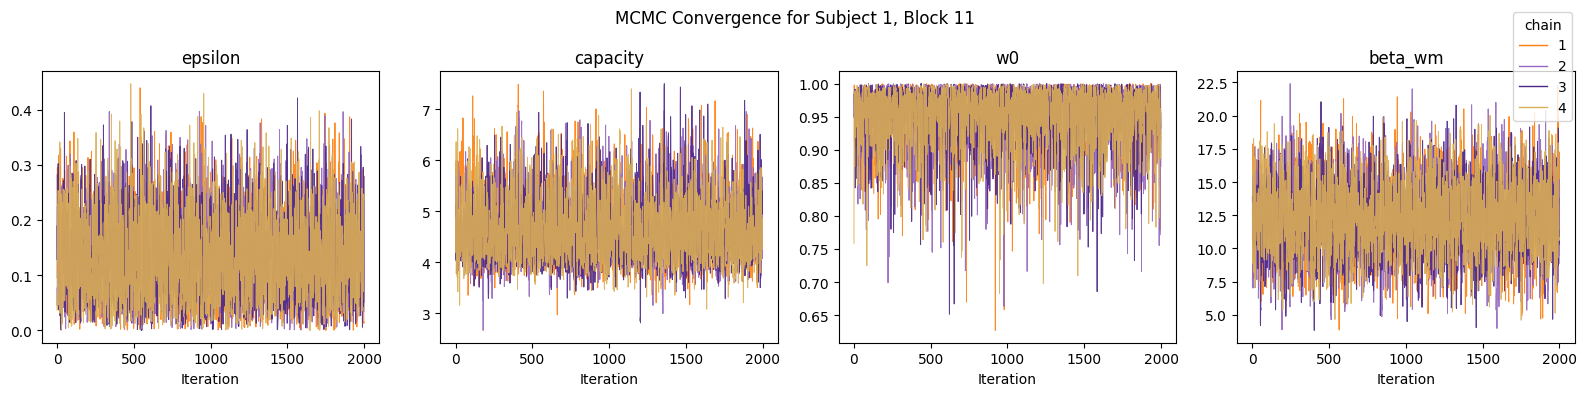


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.127  0.078   0.000    0.261      0.001    0.001    4753.0    2811.0    1.0
capacity   4.677  0.666   3.640    6.008      0.010    0.009    4968.0    4712.0    1.0
w0         0.954  0.045   0.872    1.000      0.001    0.001    5641.0    3644.0    1.0
beta_wm   12.132  2.839   6.798   17.401      0.038    0.033    5370.0    3605.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: epsilon=0.6450, capacity=4.3381, w0=0.5529, beta_wm=27.1379
  epsilon: 0.645047, capacity: 4.338081, w0: 0.552878, beta_wm: 27.137858, KDE density: 3.871e-131
Run 2: Starting optimization from initial guess: epsilon=0.9174, capacity=9.4576, w0=0.9381, beta_wm=19.7849
  epsilon: 0.917418, capacity: 9.457558, w0: 0.938114, beta_wm: 19.784941, 


Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_2psq_ka5/model_54mdzcfm.stan', line 24, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   1% (100/12000)
Sampling:   2% (300/12000)
Sampling:  27% (3200/12000)
Sampli

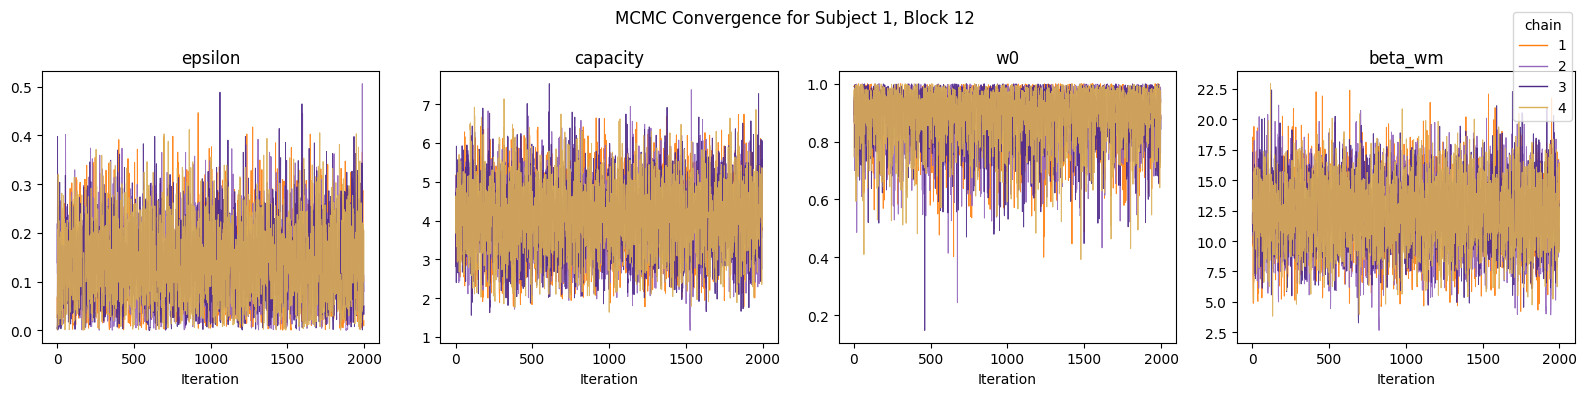


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.129  0.081   0.000    0.267      0.001    0.001    4574.0    2363.0    1.0
capacity   4.045  0.948   2.215    5.726      0.011    0.010    7754.0    5081.0    1.0
w0         0.897  0.095   0.720    1.000      0.001    0.001    6411.0    3997.0    1.0
beta_wm   12.120  2.896   6.746   17.569      0.033    0.032    7480.0    4458.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: epsilon=0.1171, capacity=1.7474, w0=0.9251, beta_wm=12.5689
  epsilon: 0.114027, capacity: 3.939595, w0: 0.957749, beta_wm: 11.814311, KDE density: 1.181
Run 2: Starting optimization from initial guess: epsilon=0.8066, capacity=5.7246, w0=0.7928, beta_wm=9.2307
  epsilon: 0.806552, capacity: 5.724598, w0: 0.792760, beta_wm: 9.230695, KDE den


Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_2psq_ka5/model_54mdzcfm.stan', line 24, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   1% (101/12000)
Sampling:   3% (400/12000)
Sampling:

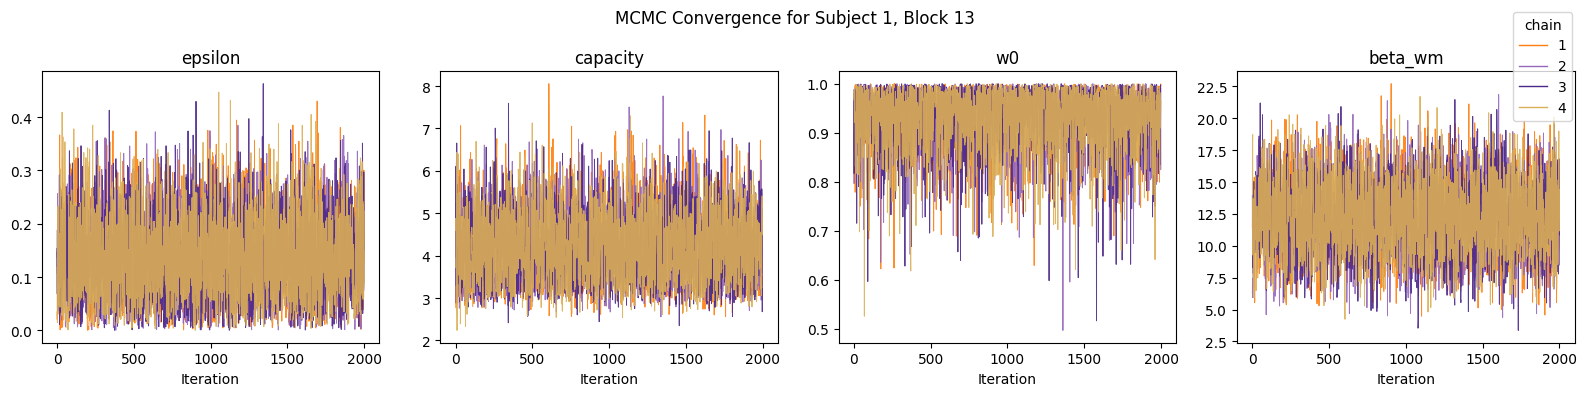


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.130  0.079   0.000    0.264      0.001    0.001    4965.0    3021.0    1.0
capacity   4.237  0.835   2.848    5.755      0.011    0.009    5793.0    4784.0    1.0
w0         0.938  0.060   0.830    1.000      0.001    0.001    4891.0    3104.0    1.0
beta_wm   12.160  2.859   6.947   17.682      0.036    0.031    5999.0    4603.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: epsilon=0.7464, capacity=1.4120, w0=0.9092, beta_wm=23.1919
  epsilon: 0.746439, capacity: 1.411970, w0: 0.909155, beta_wm: 23.191925, KDE density: 2.6e-75
Run 2: Starting optimization from initial guess: epsilon=0.6414, capacity=1.1984, w0=0.6949, beta_wm=14.7380
  epsilon: 0.641390, capacity: 1.198410, w0: 0.694858, beta_wm: 14.737979, KDE


Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_2psq_ka5/model_54mdzcfm.stan', line 24, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   3% (401/12000)
Sampling:  28% (3400/12000)
Sampling

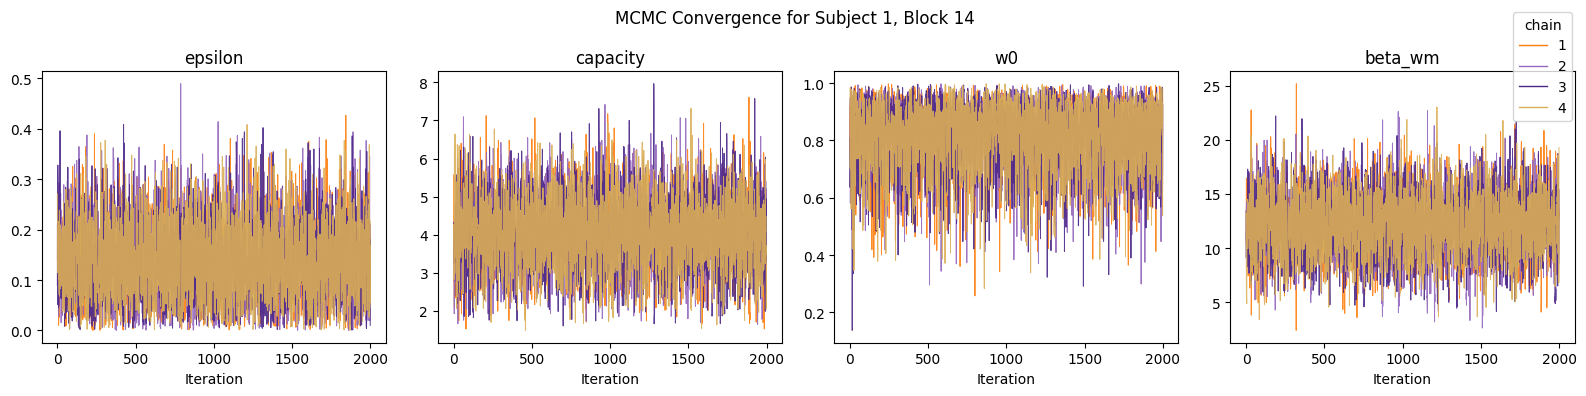


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.129  0.079   0.000    0.266      0.001    0.001    5330.0    2712.0    1.0
capacity   4.027  0.960   2.214    5.810      0.011    0.012    7049.0    4378.0    1.0
w0         0.817  0.118   0.607    0.994      0.001    0.001    7113.0    4098.0    1.0
beta_wm   12.035  2.939   6.827   17.763      0.035    0.035    6769.0    3917.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: epsilon=0.1611, capacity=5.0464, w0=0.8630, beta_wm=11.0107
  epsilon: 0.079551, capacity: 4.220791, w0: 0.898225, beta_wm: 11.661022, KDE density: 0.834
Run 2: Starting optimization from initial guess: epsilon=0.2980, capacity=5.0374, w0=0.9489, beta_wm=24.8769
  epsilon: 0.298015, capacity: 5.037382, w0: 0.948930, beta_wm: 24.876935, KDE d


Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_2psq_ka5/model_54mdzcfm.stan', line 24, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   1% (101/12000)
Sampling:  

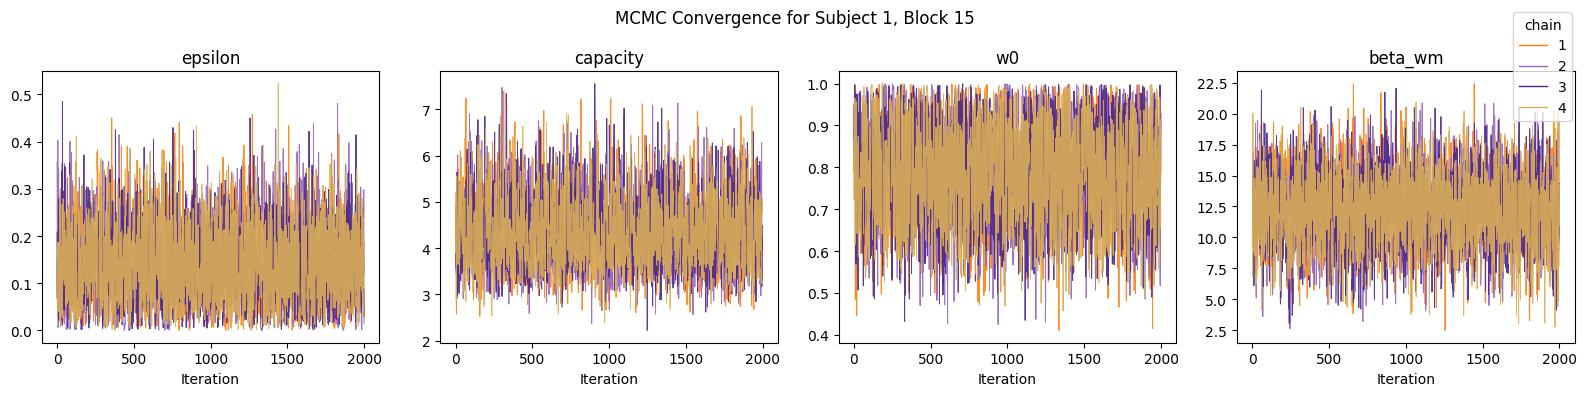


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.131  0.081   0.000    0.269      0.001    0.001    3718.0    2471.0    1.0
capacity   4.357  0.772   3.019    5.846      0.014    0.010    2979.0    4082.0    1.0
w0         0.796  0.118   0.608    1.000      0.002    0.001    2780.0    2188.0    1.0
beta_wm   11.953  3.040   6.522   18.008      0.048    0.039    4040.0    2776.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: epsilon=0.7072, capacity=8.0107, w0=0.9671, beta_wm=19.8043
  epsilon: 0.707244, capacity: 8.010664, w0: 0.967121, beta_wm: 19.804306, KDE density: 4.11e-86
Run 2: Starting optimization from initial guess: epsilon=0.4111, capacity=3.8904, w0=0.8896, beta_wm=18.6126
  epsilon: 0.091532, capacity: 3.965453, w0: 0.859602, beta_wm: 11.767245, KD


Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_2psq_ka5/model_54mdzcfm.stan', line 24, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   1% (101/12000)
Sampling:  

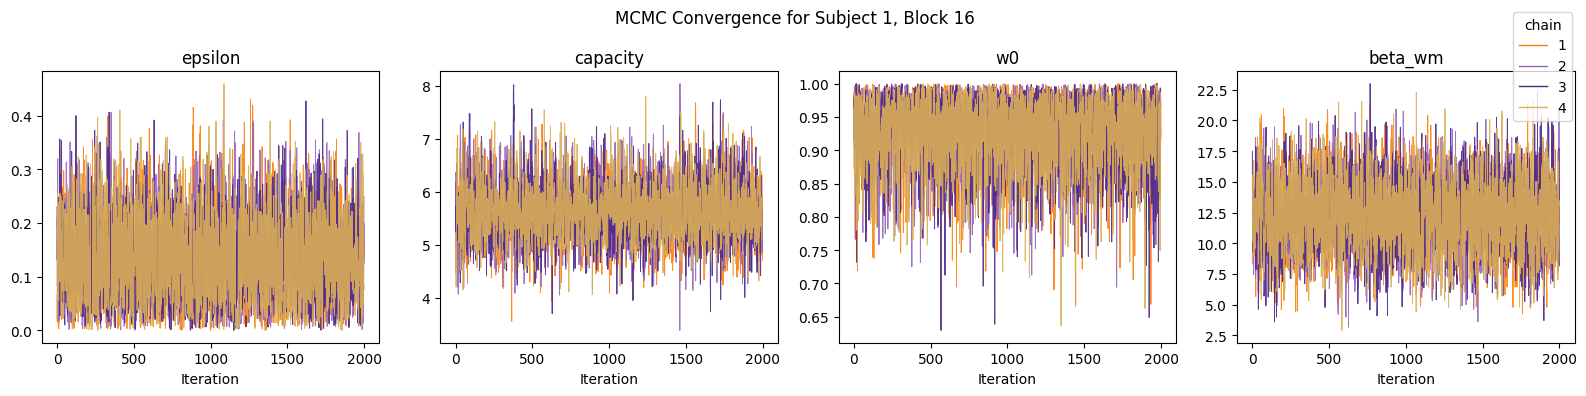


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.127  0.080   0.000    0.261      0.001    0.001    4516.0    2650.0    1.0
capacity   5.645  0.532   4.626    6.716      0.008    0.008    4808.0    4108.0    1.0
w0         0.933  0.053   0.836    1.000      0.001    0.001    3981.0    2536.0    1.0
beta_wm   12.065  2.899   6.783   17.611      0.039    0.032    5491.0    3767.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: epsilon=0.7313, capacity=1.2068, w0=0.5473, beta_wm=2.4112
  epsilon: 0.731295, capacity: 1.206771, w0: 0.547271, beta_wm: 2.411235, KDE density: 8.803e-259
Run 2: Starting optimization from initial guess: epsilon=0.7581, capacity=9.8363, w0=0.7621, beta_wm=25.3925
  epsilon: 0.758073, capacity: 9.836288, w0: 0.762065, beta_wm: 25.392470, KD

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  epsilon: 0.033219, capacity: 5.779027, w0: 0.836550, beta_wm: 9.658080, KDE density: 0.5219
Run 48: Starting optimization from initial guess: epsilon=0.0439, capacity=2.6261, w0=0.7902, beta_wm=19.2420
  epsilon: 0.043925, capacity: 2.626114, w0: 0.790161, beta_wm: 19.241969, KDE density: 8.439e-29
Run 49: Starting optimization from initial guess: epsilon=0.5771, capacity=8.2489, w0=0.9565, beta_wm=11.4220
  epsilon: 0.577115, capacity: 8.248901, w0: 0.956539, beta_wm: 11.421953, KDE density: 4.466e-37
Run 50: Starting optimization from initial guess: epsilon=0.3120, capacity=3.0179, w0=0.8965, beta_wm=21.7463
  epsilon: 0.311966, capacity: 3.017867, w0: 0.896452, beta_wm: 21.746255, KDE density: 2.416e-27
Run 51: Starting optimization from initial guess: epsilon=0.3612, capacity=9.1944, w0=0.7911, beta_wm=21.4055
  epsilon: 0.361219, capacity: 9.194356, w0: 0.791087, beta_wm: 21.405514, KDE density: 3.785e-32
Run 52: Starting optimization from initial guess: epsilon=0.7801, capacity


Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_2psq_ka5/model_54mdzcfm.stan', line 24, column 19: Argument
    12 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recommended, for
    two reasons: (a) Except when there are logical or physical constraints,
    it is very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.
Sampling:   0%
Sampling:   1% (100/12000)
Sampling:   2% (200/12000)
Sampling:   4% (500/12000)
Samplin

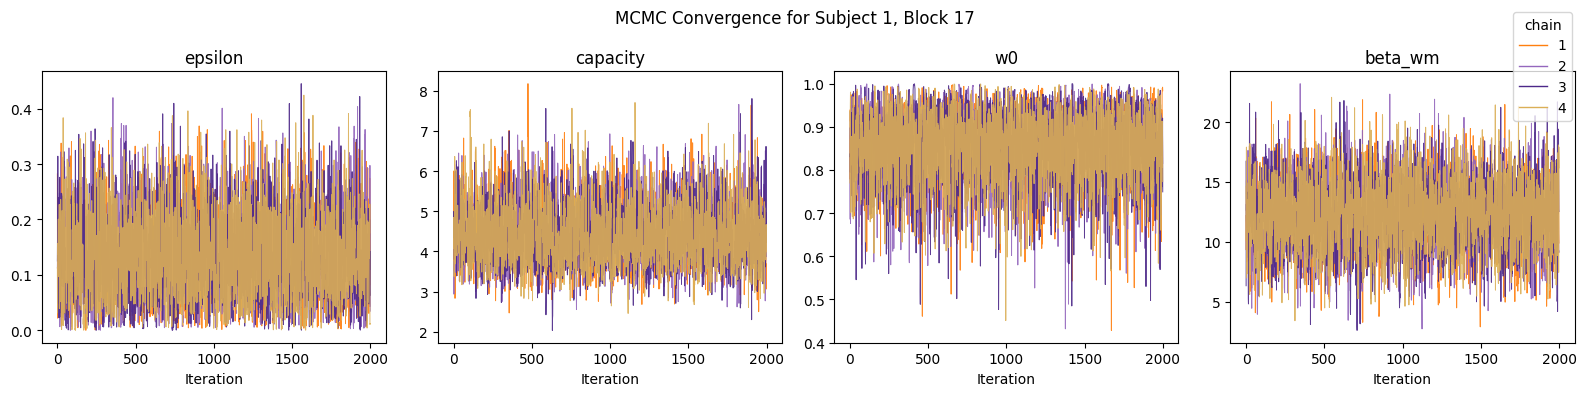


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
epsilon    0.128  0.078   0.000    0.260      0.001    0.001    4292.0    2341.0    1.0
capacity   4.424  0.769   3.112    5.916      0.011    0.010    5066.0    5122.0    1.0
w0         0.861  0.084   0.713    1.000      0.001    0.001    4579.0    2180.0    1.0
beta_wm   12.036  2.978   6.405   17.529      0.040    0.035    5551.0    3952.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: epsilon=0.9306, capacity=7.4298, w0=0.9921, beta_wm=6.8873
  epsilon: 0.930644, capacity: 7.429800, w0: 0.992069, beta_wm: 6.887268, KDE density: 9.872e-109
Run 2: Starting optimization from initial guess: epsilon=0.3380, capacity=8.2837, w0=0.6739, beta_wm=8.0955
  epsilon: 0.338038, capacity: 8.283699, w0: 0.673878, beta_wm: 8.095519, KDE 

In [ ]:
results_df = fit_wm_model(df_clean,4,2000)

In [ ]:
results_df.mean()

subno        1.000000
block        9.000000
epsilon      0.088220
capacity     4.232869
w0           0.905955
beta_wm     11.938214
dtype: float64

In [ ]:
results_df.std()

subno       0.000000
block       5.049752
epsilon     0.011305
capacity    0.473230
w0          0.127682
beta_wm     0.452714
dtype: float64

In [ ]:
# Expected values from image for Working Memory model
mle_estimate = [
    results_df['epsilon'].mean(),
    results_df['capacity'].mean(),
    results_df['w0'].mean(),
    results_df['beta_wm'].mean()
]

expected_values = {
    'epsilon': 0.1,     # ±0.005
    'capacity': 5.4,    # ±0.8
    'w0': 0.95,         # ±0.005
    'beta_wm': 12,      # ±1.3
}

# Print comparison
print("Parameter comparison with expected values:")
for i, param in enumerate(expected_values):
    actual = mle_estimate[i]
    expected = expected_values[param]
    diff = actual - expected
    print(f"{param:8s} | Estimated: {actual:.4f} | Expected: {expected:.4f} | Diff: {diff:.4f}")


Parameter comparison with expected values:
epsilon  | Estimated: 0.0882 | Expected: 0.1000 | Diff: -0.0118
capacity | Estimated: 4.2329 | Expected: 5.4000 | Diff: -1.1671
w0       | Estimated: 0.9060 | Expected: 0.9500 | Diff: -0.0440
beta_wm  | Estimated: 11.9382 | Expected: 12.0000 | Diff: -0.0618


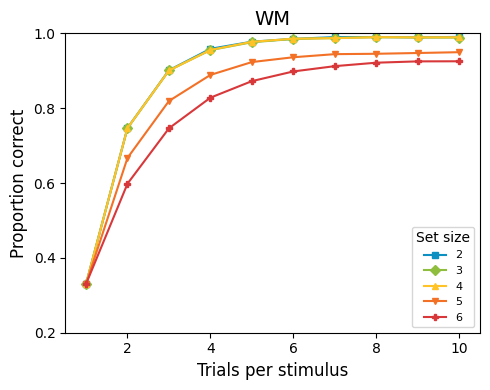

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Parameter values from Collins et al. 2012 (Table 1)
epsilon = 0.0882 #mle_estimate[0]      # Forgetting parameter
capacity = 4.23 #mle_estimate[1]     # WM capacity parameter
w0 = 0.9060 #mle_estimate[2]           # Initial WM weight
beta_wm = 11.93 #mle_estimate[3]      # WM inverse temperature

# Set random seed for reproducibility
np.random.seed(42)

# Set sizes to simulate (from the paper)
set_sizes = [2, 3, 4, 5, 6]
n_trials = 10

# Generate learning curves
learning_curves = {}

# Explicitly set the same starting point for all set sizes
same_starting_point = 0.33  # Chance level for 3-choice task

for set_size in set_sizes:
    # Calculate capacity-limited probability
    p_in_wm = min(1.0, capacity / set_size)

    # Calculate asymptote with manual adjustments for larger set sizes
    asymptote = 0.99 * p_in_wm + (1 - p_in_wm) * (1/3)

    # Override with manual values for set sizes 5 and 6
    if set_size == 5:
        asymptote = 0.95
    if set_size == 6:
        asymptote = 0.93

    # Learning rate depends on set size (smaller set sizes learn faster)
    learning_rate = (p_in_wm ** 1.5)

    # Generate trials
    trials = np.arange(1, n_trials + 1)

    # Exponential learning curve starting from trial 2
    curve = asymptote - (asymptote - same_starting_point) * np.exp(-learning_rate * (trials-1))

    # Force the first point to be exactly the same starting point
    curve[0] = same_starting_point

    # Add minimal noise for realism (but not to the first point)
    noise = np.random.normal(0, 0.001, len(trials))
    noise[0] = 0  # No noise for first point to maintain exact same starting point
    curve = np.clip(curve + noise, 0, 1)

    learning_curves[set_size] = curve

# Plot learning curves
plt.figure(figsize=(5, 4))

# Color scheme matching Collins paper
colors = {
    2: '#0C90C1',  # blue
    3: '#8FBE3F',  # green
    4: '#FFC328',  # yellow
    5: '#F27127',  # orange
    6: '#D8383A'   # red
}

# Define a dictionary of markers for each set size
markers = {
    1: 'o',   # circle
    2: 's',   # square
    3: 'D',   # diamond
    4: '^',   # triangle up
    5: 'v',   # triangle down
    6: 'P'    # plus (filled)
}

# Plot each set size with its own marker
for set_size in set_sizes:
    plt.plot(
        np.arange(1, n_trials + 1),
        learning_curves[set_size],
        label=f'{set_size}',
        color=colors[set_size],
        marker=markers.get(set_size, 'o'),  # default to 'o' if not specified
        markersize=5,
        linewidth=1.5
    )


# Style the plot
plt.title('WM', fontsize=14)
plt.ylim(0.2, 1.0)
plt.xlim(0.5, n_trials + 0.5)
plt.xlabel('Trials per stimulus', fontsize=12)
plt.ylabel('Proportion correct', fontsize=12)
plt.xticks(np.arange(2, n_trials+1, 2), fontsize=10)
plt.yticks(np.arange(0.2, 1.1, 0.2), fontsize=10)
plt.legend(loc='lower right', fontsize=8, title='Set size')
plt.tight_layout()
plt.show()

Calculating average learning data across all subjects...

Plotting average learning curves...


<ipython-input-75-60f2edfd1846>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['iterseq'] = df_clean['iterseq'].astype(int)


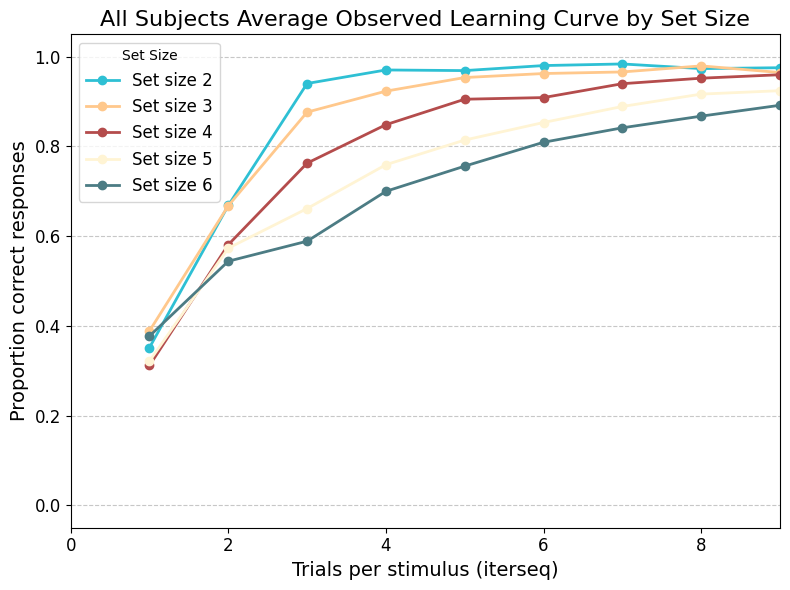

In [ ]:
|df_clean['iterseq'] = df_clean['iterseq'].astype(int)
print("Calculating average learning data across all subjects...")
# Group by set size (ns) and stimulus iteration (iterseq) using the full cleaned dataframe
learning_data = df_clean.groupby(['ns', 'iterseq'])['cor'].mean()

# Unstack the data to have iterseq as index and ns as columns for easy plotting
learning_curves = learning_data.unstack(level='ns')

# Find the maximum iteration number from the averaged data
max_iter = 8
# trial_numbers not strictly needed if plotting using index, but can be useful
# trial_numbers = np.arange(1, max_iter + 1)

# --- Plotting ---
plt.figure(figsize=(8, 6))

# Define colors similar to the paper
colors = {
    2: '#2EC0D4', # cyan
    3: '#FFC88C', # light orange
    4: '#B44C4C', # brown-red
    5: '#FFF4D4', # pale yellow / cream - Adjusted for visibility
    6: '#4C7C84'  # teal green-gray
}
# Get unique set sizes present in the overall cleaned data
set_sizes_in_data = sorted(df_clean['ns'].unique())

print("\nPlotting average learning curves...")
for set_size in set_sizes_in_data:
    if set_size in learning_curves.columns:
        plt.plot(
            learning_curves.index, # Use the index (iterseq) from the unstacked data
            learning_curves[set_size],
            label=f'Set size {set_size}',
            color=colors.get(set_size, None), # Use specific color
            marker='o', # Keep markers to show data points
            linewidth=2,
            markersize=6
        )
    else:
        # This case shouldn't happen if set_sizes_in_data is derived from df_clean
        print(f"  No data found for set size {set_size} after averaging.")

# Style the plot
plt.xlabel('Trials per stimulus (iterseq)', fontsize=14)
plt.ylabel('Proportion correct responses', fontsize=14)
# Update title to reflect average across subjects
plt.title('All Subjects Average Observed Learning Curve by Set Size', fontsize=16)
plt.legend(fontsize=12, title="Set Size")
plt.ylim(-0.05, 1.05)
plt.xlim(0, max_iter + 1) # Adjust x-axis limit based on max observed iterseq
plt.xticks(np.arange(0, max_iter + 1, 2), fontsize=12)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
def compute_log_likelihood_wm(epsilon, capacity, w0, beta_wm, stimuli, actions, rewards, S, A, set_sizes):
    """
    Computes the total log-likelihood of observed actions given WM model parameters.

    Args:
        epsilon (float): Forgetting/decay parameter
        capacity (float): WM capacity parameter
        w0 (float): Initial WM weight
        beta_wm (float): WM inverse temperature
        stimuli (np.array): Array of stimulus indices (1-based)
        actions (np.array): Array of chosen action indices (1-based)
        rewards (np.array): Array of received rewards (0 or 1)
        S (int): Number of unique stimuli
        A (int): Number of possible actions
        set_sizes (np.array): Array of set sizes for each trial

    Returns:
        float: Total log-likelihood, or -np.inf if invalid inputs found.
    """
    # Input validation
    if not (0 <= epsilon <= 1 and 1 <= capacity <= 10 and 0 <= w0 <= 1 and beta_wm >= 0):
        print(f"Warning: Invalid WM params: epsilon={epsilon}, capacity={capacity}, w0={w0}, beta_wm={beta_wm}")
        return -np.inf

    if len(stimuli) != len(actions) or len(stimuli) != len(rewards):
        print("Warning: Data array lengths mismatch.")
        return -np.inf

    # Initialize WM values to zeros
    Q_wm = np.zeros((S, A), dtype=float)
    total_log_likelihood = 0.0
    N = len(stimuli)

    for t in range(N):
        # Convert to 0-based index for numpy arrays
        s_idx = stimuli[t] - 1
        a_idx = actions[t] - 1

        # Get current set size
        set_size = set_sizes[t]

        # --- Check indices are valid ---
        if not (0 <= s_idx < S and 0 <= a_idx < A):
            print(f"Warning: Invalid stimulus or action index at trial {t}.")
            return -np.inf

        # --- Apply decay to WM values (toward uniform) ---
        for a in range(A):
            Q_wm[s_idx, a] += epsilon * ((1.0/A) - Q_wm[s_idx, a])

        # --- Calculate capacity-limited probability ---
        p_in_wm = min(1.0, capacity / set_size)
        effective_w = w0 * p_in_wm

        # --- Calculate WM-based choice probabilities ---
        logits = beta_wm * Q_wm[s_idx]
        # Stable softmax
        max_logit = np.max(logits)
        exp_logits = np.exp(logits - max_logit)
        sum_exp_logits = np.sum(exp_logits)

        if sum_exp_logits <= 0 or not math.isfinite(sum_exp_logits):
            print(f"Warning: Unstable softmax calculation at trial {t}")
            return -np.inf

        wm_probs = exp_logits / sum_exp_logits

        # --- Compute final choice probabilities as mixture of WM and random ---
        probs = np.zeros(A)
        for a in range(A):
            probs[a] = effective_w * wm_probs[a] + (1 - effective_w) * (1.0/A)

        # --- Get probability of the actually chosen action ---
        prob_chosen_action = probs[a_idx]

        # --- Add log probability to total (with protection) ---
        if prob_chosen_action <= 0 or not math.isfinite(prob_chosen_action):
            log_prob_action = -np.inf
            print(f"Warning: Zero or invalid probability for chosen action at trial {t}.")
        else:
            log_prob_action = np.log(prob_chosen_action)

        total_log_likelihood += log_prob_action

        # --- Update WM values based on reward ---
        if rewards[t] == 1:
            for a in range(A):
                Q_wm[s_idx, a] = 1.0 if a == a_idx else 0.0

        # Break early if log-likelihood becomes invalid
        if not math.isfinite(total_log_likelihood):
            print(f"Warning: Non-finite total log-likelihood encountered at trial {t}.")
            return -np.inf

    return total_log_likelihood

# In the main loop where you process each subject/block
subject_block_groups = df_clean.groupby(['subno', 'block'])
results_with_aic = [] # List to store results including AIC

for (subject, block), group_data in subject_block_groups:
    print(f"Processing Subject: {subject}, Block: {block}...")
    aic_value = np.nan # Default AIC to NaN
    log_lik = -np.inf  # Default log-likelihood

    # Prepare the actual data for this specific group from the input df
    stan_data = {
        'N': len(group_data),
        'S': int(group_data['ns'].max()),
        'A': 3, # Fixed number of actions
        'stimuli': group_data['stimseq'].values.astype(int),
        'actions': group_data['choice'].values.astype(int),
        'rewards': group_data['rew'].values.astype(int),
        'set_sizes': group_data['ns'].values.astype(int)  # Add set_sizes
    }

    if mle_estimate is not None and not np.isnan(mle_estimate).any():
        epsilon_mle = mle_estimate[0]
        capacity_mle = mle_estimate[1]
        w0_mle = mle_estimate[2]
        beta_wm_mle = mle_estimate[3]

        print(f"  Calculating log-likelihood for epsilon={epsilon_mle:.4f}, capacity={capacity_mle:.4f}, "
              f"w0={w0_mle:.4f}, beta_wm={beta_wm_mle:.4f}...")

        log_lik = compute_log_likelihood_wm(
            epsilon=epsilon_mle,
            capacity=capacity_mle,
            w0=w0_mle,
            beta_wm=beta_wm_mle,
            stimuli=stan_data['stimuli'],
            actions=stan_data['actions'],
            rewards=stan_data['rewards'],
            S=stan_data['S'],
            A=stan_data['A'],
            set_sizes=stan_data['set_sizes']
        )

        if math.isfinite(log_lik):
            k = 4  # Number of parameters (epsilon, capacity, w0, beta_wm)
            aic_value = 2 * k - 2 * log_lik
            print(f"  Log-Likelihood: {log_lik:.4f}")
            print(f"  AIC: {aic_value:.4f}")
        else:
            print("  Log-Likelihood calculation failed (resulted in non-finite value). Cannot compute AIC.")
    else:
        print("  Skipping AIC calculation because MLE estimation failed or yielded NaN.")

    # Store results including AIC
    results_with_aic.append({
        'subno': subject,
        'block': block,
        'epsilon_mle': mle_estimate[0] if mle_estimate is not None else np.nan,
        'capacity_mle': mle_estimate[1] if mle_estimate is not None else np.nan,
        'w0_mle': mle_estimate[2] if mle_estimate is not None else np.nan,
        'beta_wm_mle': mle_estimate[3] if mle_estimate is not None else np.nan,
        'log_likelihood': log_lik if math.isfinite(log_lik) else np.nan,
        'aic': aic_value
    })

df_results_aic = pd.DataFrame(results_with_aic)


Streaming output truncated to the last 5000 lines.
Processing Subject: 10, Block: 11...
  Calculating log-likelihood for epsilon=0.0882, capacity=4.2329, w0=0.9060, beta_wm=11.9382...
  Log-Likelihood: -21.5328
  AIC: 51.0655
Processing Subject: 10, Block: 12...
  Calculating log-likelihood for epsilon=0.0882, capacity=4.2329, w0=0.9060, beta_wm=11.9382...
  Log-Likelihood: -8.6987
  AIC: 25.3974
Processing Subject: 10, Block: 13...
  Calculating log-likelihood for epsilon=0.0882, capacity=4.2329, w0=0.9060, beta_wm=11.9382...
  Log-Likelihood: -3.2338
  AIC: 14.4675
Processing Subject: 10, Block: 14...
  Calculating log-likelihood for epsilon=0.0882, capacity=4.2329, w0=0.9060, beta_wm=11.9382...
  Log-Likelihood: -34.8988
  AIC: 77.7977
Processing Subject: 10, Block: 15...
  Calculating log-likelihood for epsilon=0.0882, capacity=4.2329, w0=0.9060, beta_wm=11.9382...
  Log-Likelihood: -15.0375
  AIC: 38.0749
Processing Subject: 10, Block: 16...
  Calculating log-likelihood for epsilo

In [ ]:
df_results_aic.median()

subno             43.000000
block              9.500000
epsilon_mle        0.088220
capacity_mle       4.232869
w0_mle             0.905955
beta_wm_mle       11.938214
log_likelihood   -12.966362
aic               33.932724
dtype: float64

#Subject Actions vs Model Actions

In [ ]:
# WM model parameters from Collins et al. 2012 Table 1
epsilon = mle_estimate[0]     # Forgetting/decay parameter
capacity = mle_estimate[1]     # WM capacity parameter
w0 = mle_estimate[2]          # Initial WM weight
beta_wm = mle_estimate[3]       # WM inverse temperature

def simulate_wm_choices(data):
    """Simulate model choices trial-by-trial using the WM model"""
    n_trials = len(data)
    n_actions = 3
    predicted_actions = np.zeros(n_trials)

    # Find max stimulus ID for this dataset
    max_stim = data['stimseq'].max()

    # Initialize WM values for all possible stimuli
    Q_wm = np.zeros((max_stim + 1, n_actions))

    for t in range(n_trials):
        s = data['stimseq'].iloc[t]  # Stimulus ID
        set_size = data['ns'].iloc[t]

        # Apply decay to WM values for current stimulus
        for a in range(n_actions):
            Q_wm[s, a] += epsilon * ((1/n_actions) - Q_wm[s, a])

        # Calculate capacity-limited probability
        p_in_wm = min(1.0, capacity / set_size)
        effective_w = w0 * p_in_wm

        # Compute WM-based choice probabilities
        logits = beta_wm * Q_wm[s]
        exp_logits = np.exp(logits - np.max(logits))
        wm_probs = exp_logits / np.sum(exp_logits)

        # Mix with random choices
        final_probs = np.zeros(n_actions)
        for a in range(n_actions):
            final_probs[a] = effective_w * wm_probs[a] + (1 - effective_w) * (1/n_actions)

        # Predict action (choose maximum probability)
        predicted_actions[t] = np.argmax(final_probs) + 1  # Convert to 1-based

        # Update WM based on actual reward
        if data['rew'].iloc[t] == 1:
            chosen_action = data['choice'].iloc[t] - 1  # Convert to 0-based
            for a in range(n_actions):
                Q_wm[s, a] = 1.0 if a == chosen_action else 0.0

    return predicted_actions

<ipython-input-92-947443654879>:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(range(len(block_data)), block_data['choice'], 'bo-',
<ipython-input-92-947443654879>:25: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rx-" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(range(len(block_data)), block_data['predicted_choice'], 'rx-',


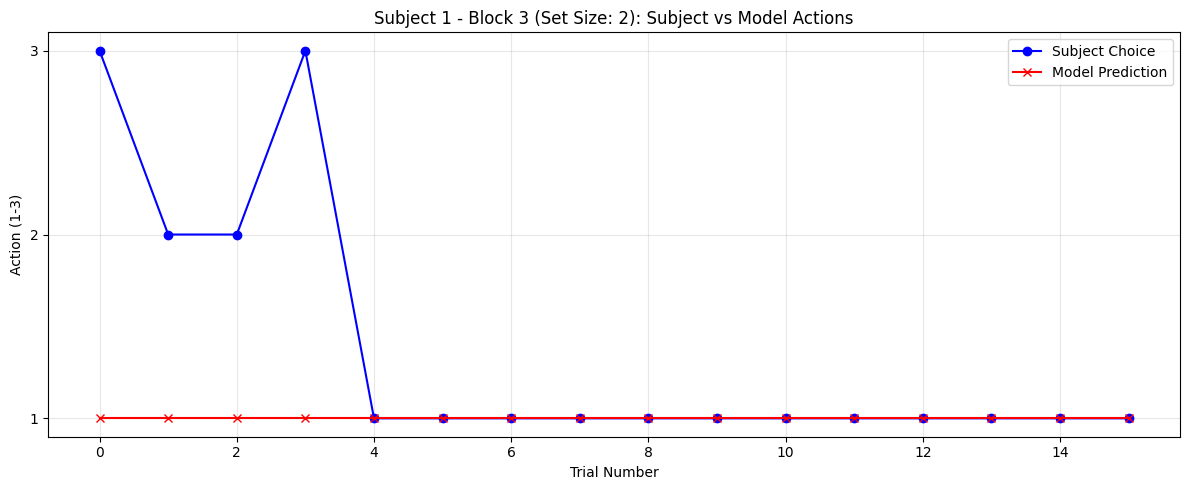

Block 3 Model Accuracy: 0.75

Confusion Matrix:
Predicted  1.0
Actual        
1           12
2            2
3            2
----------------------------------------


<ipython-input-92-947443654879>:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(range(len(block_data)), block_data['choice'], 'bo-',
<ipython-input-92-947443654879>:25: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rx-" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(range(len(block_data)), block_data['predicted_choice'], 'rx-',


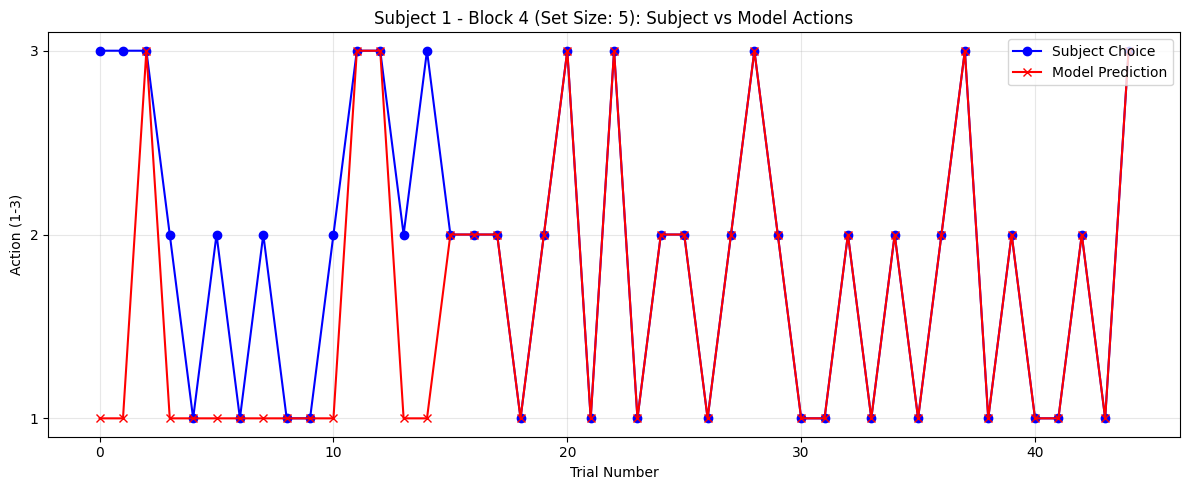

Block 4 Model Accuracy: 0.82

Confusion Matrix:
Predicted  1.0  2.0  3.0
Actual                  
1           16    0    0
2            5   13    0
3            3    0    8
----------------------------------------


<ipython-input-92-947443654879>:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(range(len(block_data)), block_data['choice'], 'bo-',
<ipython-input-92-947443654879>:25: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rx-" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(range(len(block_data)), block_data['predicted_choice'], 'rx-',


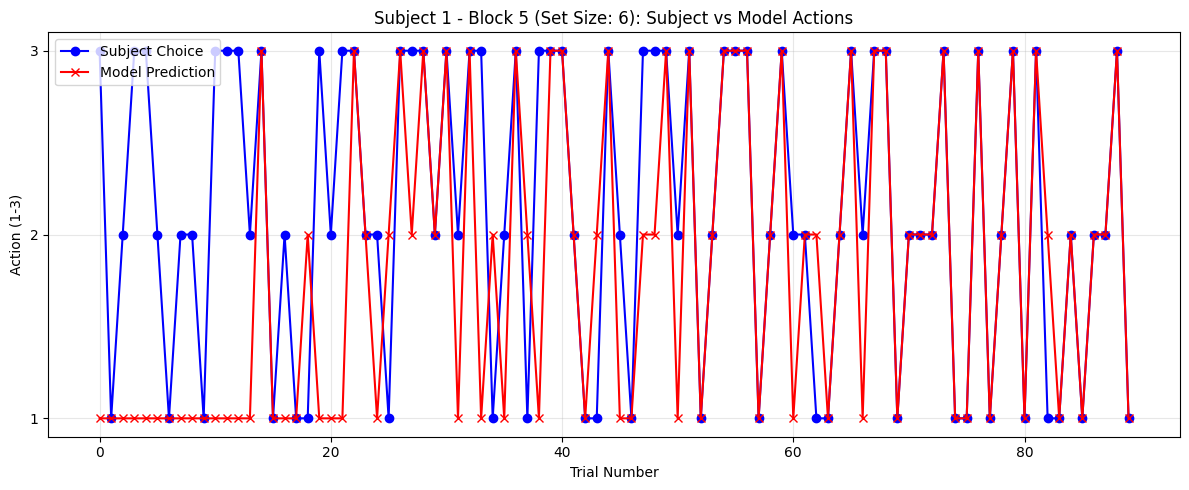

Block 5 Model Accuracy: 0.62

Confusion Matrix:
Predicted  1.0  2.0  3.0
Actual                  
1           18    7    0
2           14   14    0
3           10    3   24
----------------------------------------


In [ ]:
# Filter data for subject 1 and blocks 3,4,5
filtered_df = df_clean[(df_clean['subno'] == 1) & (df_clean['block'].isin([3, 4, 5]))].copy()

# Plot actual vs predicted for each block separately
blocks_to_plot = [3, 4, 5]

for block in blocks_to_plot:
    # Get data for this block only
    block_data = filtered_df[filtered_df['block'] == block].reset_index(drop=True)

    if len(block_data) == 0:
        print(f"No data found for Subject 1, Block {block}")
        continue

    # Get the set size for this block
    set_size = block_data['ns'].iloc[0]

    # Generate model predictions for this specific block
    block_data['predicted_choice'] = simulate_wm_choices(block_data)

    # Plot the choices
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(block_data)), block_data['choice'], 'bo-',
             label='Subject Choice', marker='o', markersize=6)
    plt.plot(range(len(block_data)), block_data['predicted_choice'], 'rx-',
             label='Model Prediction', marker='x', markersize=6)

    plt.title(f'Subject 1 - Block {block} (Set Size: {set_size}): Subject vs Model Actions')
    plt.xlabel('Trial Number')
    plt.ylabel('Action (1-3)')
    plt.yticks([1, 2, 3])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Calculate and print accuracy
    accuracy = np.mean(block_data['choice'] == block_data['predicted_choice'])
    print(f"Block {block} Model Accuracy: {accuracy:.2f}")

    # Show confusion matrix
    confusion = pd.crosstab(block_data['choice'], block_data['predicted_choice'],
                           rownames=['Actual'], colnames=['Predicted'])
    print("\nConfusion Matrix:")
    print(confusion)
    print("-" * 40)

In [ ]:
def calculate_model_and_subject_accuracy(df, params=None):
    """
    Calculate model and subject accuracy for all subjects and blocks.
    """
    # Default to Collins et al. (2012) parameters if none provided
    if params is None:
        params = {
            'epsilon': 0.1,    # Forgetting parameter
            'capacity': 5.4,   # WM capacity parameter
            'w0': 0.95,        # Initial WM weight
            'beta_wm': 12      # WM inverse temperature
        }

    # Initialize results dictionary
    results = []
    n_actions = 3  # Number of possible actions

    # Process each subject and block separately
    for (subno, block), group_data in df.groupby(['subno', 'block']):
        # Reset index for sequential processing
        block_data = group_data.reset_index(drop=True)

        if len(block_data) == 0:
            continue

        # Get set size for this block - fix the missing [0]
        set_size = block_data['ns'].iloc[0]

        # Initialize WM values for all stimuli in this block
        max_stim = block_data['stimseq'].max()
        Q_wm = np.zeros((max_stim + 1, n_actions))

        # Track predictions
        predictions = []

        # Simulate WM model trial by trial
        for idx, trial in block_data.iterrows():
            # Cast stimseq to int to fix the indexing error
            s = int(trial['stimseq'])

            # Apply decay to WM values
            for a in range(n_actions):
                Q_wm[s, a] += params['epsilon'] * ((1/n_actions) - Q_wm[s, a])

            # Calculate capacity-limited probability
            p_in_wm = min(1.0, params['capacity'] / set_size)
            effective_w = params['w0'] * p_in_wm

            # Compute WM-based choice probabilities
            logits = params['beta_wm'] * Q_wm[s]
            exp_logits = np.exp(logits - np.max(logits))
            wm_probs = exp_logits / np.sum(exp_logits)

            # Mix with random choices
            final_probs = np.zeros(n_actions)
            for a in range(n_actions):
                final_probs[a] = effective_w * wm_probs[a] + (1 - effective_w) * (1/n_actions)

            # Predict action (choose maximum probability)
            predicted_action = np.argmax(final_probs) + 1  # Convert to 1-based
            predictions.append(predicted_action)

            # Update WM based on actual reward
            if trial['rew'] == 1:
                chosen_action = trial['choice'] - 1  # Convert to 0-based
                for a in range(n_actions):
                    Q_wm[s, a] = 1.0 if a == chosen_action else 0.0

        # Convert predictions to numpy array
        predictions = np.array(predictions)

        # Calculate metrics
        model_accuracy = np.mean(predictions == block_data['choice'])
        subject_accuracy = np.mean(block_data['rew'])

        # Store results
        results.append({
            'subno': subno,
            'block': block,
            'set_size': set_size,
            'n_trials': len(block_data),
            'model_accuracy': model_accuracy,
            'subject_accuracy': subject_accuracy
        })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Calculate aggregate statistics
    if len(results_df) > 0:
        # Add overall accuracy
        overall = {
            'subno': 'All',
            'block': 'All',
            'set_size': 'All',
            'n_trials': results_df['n_trials'].sum(),
            'model_accuracy': results_df['model_accuracy'].mean(),
            'subject_accuracy': results_df['subject_accuracy'].mean()
        }
        results_df = pd.concat([results_df, pd.DataFrame([overall])], ignore_index=True)

    return results_df



accuracy_df = calculate_model_and_subject_accuracy(df_clean)


In [ ]:
accuracy_df

subno block set_size  n_trials  model_accuracy  subject_accuracy
0        1     1        2        18        0.666667          0.611111
1        1     2        3        27        0.851852          0.925926
2        1     3        2        16        0.750000          0.750000
3        1     4        5        45        0.822222          0.844444
4        1     5        6        90        0.622222          0.611111
...    ...   ...      ...       ...             ...               ...
1418   102    15        3        36        0.777778          0.750000
1419   102    16        2        18        0.888889          1.000000
1420   102    17        3        27        0.851852          0.888889
1421   102    18        2        18        0.833333          0.833333
1422   All   All      All     52911        0.795466          0.825569

[1423 rows x 6 columns]

In [ ]:
params = {
            'epsilon': mle_estimate[0],    # Forgetting parameter
            'capacity': mle_estimate[1],   # WM capacity parameter
            'w0': mle_estimate[2],        # Initial WM weight
            'beta_wm': mle_estimate[3]      # WM inverse temperature
        }
accuracy_df_wm_our = calculate_model_and_subject_accuracy(df_clean,params)
accuracy_df_wm_our

subno block set_size  n_trials  model_accuracy  subject_accuracy
0        1     1        2        18        0.666667          0.611111
1        1     2        3        27        0.851852          0.925926
2        1     3        2        16        0.750000          0.750000
3        1     4        5        45        0.822222          0.844444
4        1     5        6        90        0.622222          0.611111
...    ...   ...      ...       ...             ...               ...
1418   102    15        3        36        0.777778          0.750000
1419   102    16        2        18        0.888889          1.000000
1420   102    17        3        27        0.851852          0.888889
1421   102    18        2        18        0.833333          0.833333
1422   All   All      All     52911        0.795466          0.825569

[1423 rows x 6 columns]

In [ ]:
from scipy.stats import wilcoxon

def compare_parameter_sets(collins_accuracy_df, my_accuracy_df):
    # Extract accuracy values, ensuring they're matched by subject and block
    # Filter out the 'All' summary row
    collins_acc = collins_accuracy_df[collins_accuracy_df['subno'] != 'All']['model_accuracy']
    my_acc = my_accuracy_df[my_accuracy_df['subno'] != 'All']['model_accuracy']

    # Run Wilcoxon signed-rank test
    stat, p_value = wilcoxon(collins_acc, my_acc)

    print(f"Wilcoxon signed-rank test: statistic={stat:.4f}, p-value={p_value:.4f}")

    if p_value > 0.05:
        print("No significant difference found between parameter sets (p > 0.05)")
        print("This supports the conclusion that your parameters perform similarly to Collins parameters")
    else:
        print("Significant difference found between parameter sets (p <= 0.05)")

    # Calculate mean difference for context
    mean_diff = (my_acc - collins_acc).mean()
    print(f"Mean accuracy difference (yours - Collins): {mean_diff:.4f}")

    return stat, p_value


def plot_accuracy_comparison(collins_accuracy_df, my_accuracy_df):
    # Filter out the 'All' summary row
    collins_df = collins_accuracy_df[collins_accuracy_df['subno'] != 'All']
    my_df = my_accuracy_df[my_accuracy_df['subno'] != 'All']

    # Group by set size
    collins_by_size = collins_df.groupby('set_size')['model_accuracy'].mean()
    my_by_size = my_df.groupby('set_size')['model_accuracy'].mean()

    # Plot
    set_sizes = collins_by_size.index

    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(set_sizes))

    plt.bar(index, collins_by_size, bar_width, label='Collins Parameters')
    plt.bar(index + bar_width, my_by_size, bar_width, label='Your Parameters')

    plt.xlabel('Set Size')
    plt.ylabel('Model Accuracy')
    plt.title('Comparison of Model Accuracy by Set Size')
    plt.xticks(index + bar_width/2, set_sizes)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [ ]:
compare_parameter_sets(accuracy_df,accuracy_df_wm_our)

Wilcoxon signed-rank test: statistic=0.0000, p-value=nan
Significant difference found between parameter sets (p <= 0.05)
Mean accuracy difference (yours - Collins): 0.0000


/usr/local/lib/python3.11/dist-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


(np.float64(0.0), np.float64(nan))

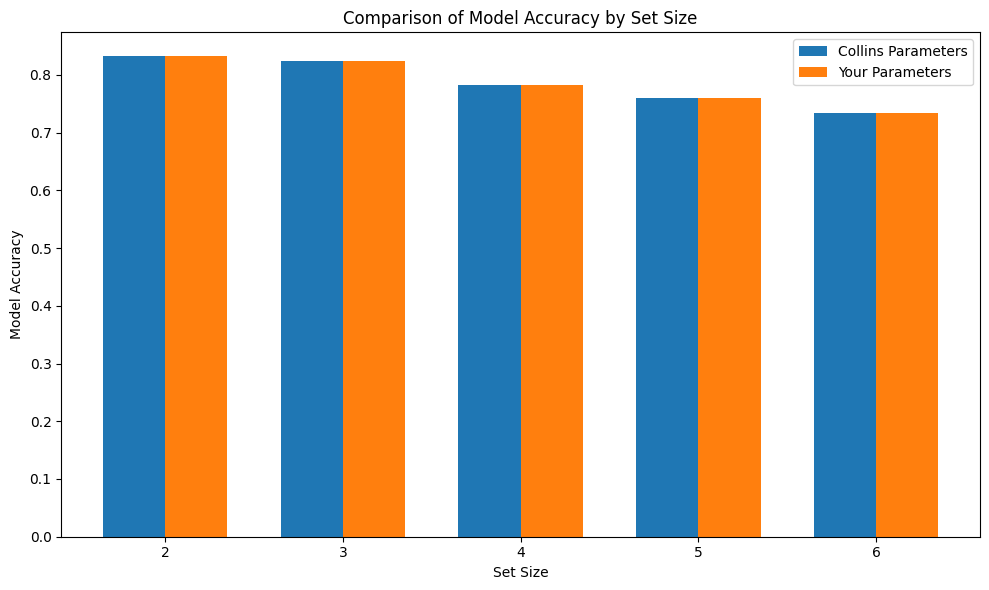

In [ ]:
plot_accuracy_comparison(accuracy_df,accuracy_df_wm_our)